In [10]:
# import packages

import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import csv

In [21]:
# load file
df = pd.read_csv('C:/Users/Admin/Documents/Federated-Learning/tutorial/groups_age.csv')

In [33]:
def split_dataframe(df : pd.DataFrame, stratify_vars: list[str], n_splits: int, random_state=42) -> list[pd.DataFrame]:
    
    
    # Step 2: Add stratify column
    # Creating a new column 'stratify_col' that concatenates the values of stratify_vars
    df['stratify_col'] = df[stratify_vars].astype(str).agg('-'.join, axis=1)
    
    # Step 3: Split
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    splits = []
    
    for _, test_index in skf.split(df, df['stratify_col']):
        splits.append(df.iloc[test_index])
    
    return splits

In [34]:
def partition_dataset(path_data_csv: str, n_splits: int, n_splits_test: float, random_state=42) -> pd.DataFrame:

    # CSV loaded 
    col_splits = f'{n_splits}_splits'
    col_age_category = 'age_category'
    stratify_vars = [col_age_category, 'age', 'sex', 'scan_site_id']

    #find the min and max age and then bin variable by two year intervals 
    # define bin edges (2 year intervals)
    bins = range(0, int(df['age'].max()) + 2, 2) 
    labels = [f'{i}-{i+2}' for i in bins[:-1]]
    df[col_age_category] = pd.cut(df['age'], bins=bins, labels=labels, right=False) 

    # get the 20% test set
    train_test_splits = split_dataframe(df=df, stratify_vars=stratify_vars, n_splits=n_splits_test, random_state=random_state)
    df_test = train_test_splits[0]
    df_test[col_splits] = -1

    df_train = pd.concat(train_test_splits[1:])
    splits = split_dataframe(df=df_train, stratify_vars=stratify_vars, n_splits=n_splits, random_state=random_state)
    for i, split in enumerate(splits):
        print(f"Split {i+1}:\n", split['stratify_col'].head())
    
    for i in range(n_splits):
        splits[i][col_splits] = int(i)

    return pd.concat(splits + [df_test])


In [45]:
## define splits
split1 = df[df['AgeGroup'] == 1]
split2 = df[df['AgeGroup'] == 2]
split3 = df[df['AgeGroup'] == 3]

splits = [split1, split2, split3]

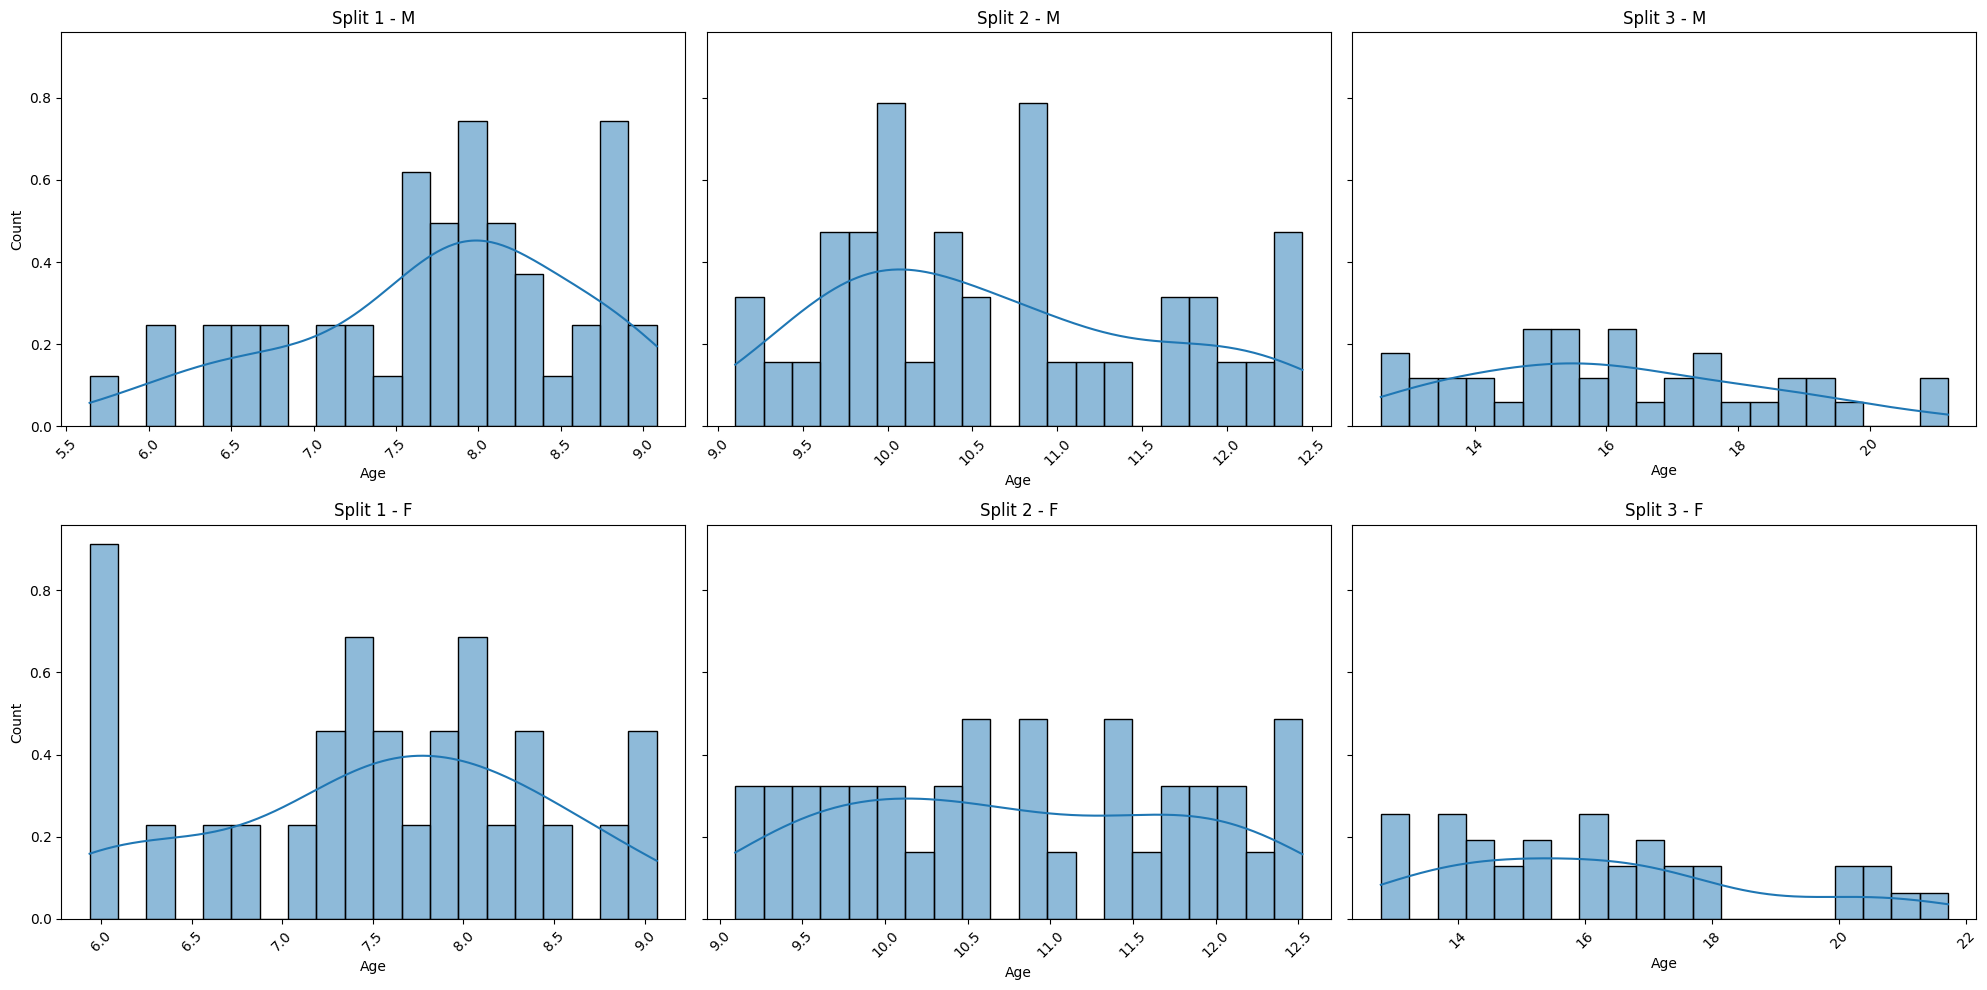

In [46]:
# sanity check for distribution 
# Plotting the original age variable 

n_splits = len(splits)
genders = df['sex'].unique()
genders = [str(gender) for gender in genders if pd.notna(gender)]  # Ensure only valid strings
n_genders = len(genders)  # Get the number of unique genders

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_genders, ncols=n_splits, figsize=(20, 10), sharey=True)

# Plot each split for each gender
for i, split in enumerate(splits):
    for j, gender in enumerate(genders):
        ax = axes[j, i]  # Use j for gender index
        sns.histplot(split[split['sex'] == gender]['age'], bins=20, ax=ax, kde=True, stat='density', alpha=0.5)
        ax.set_title(f'Split {i + 1} - {str(gender).capitalize()}')  # Ensure gender is a string
        ax.set_xlabel('Age')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()
